 <h2>Facial Keypoint Detection</h2>         


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.layers import Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
#from IPython.display import clear_output
#from time import sleep
import os, gc

Using TensorFlow backend.
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
import keras
print(keras.__version__)

2.2.4


In [3]:



# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.Session(config=config))
    
reset_keras()    

0


In [4]:
train_file = '../input/training/training.csv'
test_file = '../input/test/test.csv'
lookid_dir = '../input/IdLookupTable.csv'
train_data = pd.read_csv(train_file)  
test_data = pd.read_csv(test_file)
lookid_data = pd.read_csv(lookid_dir)

Lets explore our dataset

In [5]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


Lets check for missing values

In [6]:
train_data.isnull().any().value_counts()
columns_nan = train_data.columns[train_data.isna().any()].tolist()
train_data[columns_nan] = train_data[columns_nan].fillna(value=train_data[columns_nan].mean())

There are missing values in 28 columns. The missing values are replaced by mean values of the features.

In [7]:

x_train = []
for i in range(train_data.shape[0]):
    image = train_data['Image'][i].split(' ')
    image = ['0' if x == '' else x for x in image]
    x_train.append(image)
    
x_train = np.array(x_train,dtype = 'float')
x_train = x_train/255.0
x_train = x_train.reshape(-1,96,96,1)
    

Lets see what is the first image.

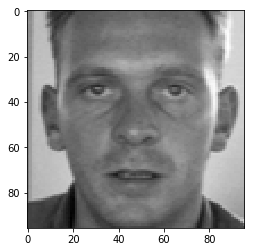

In [8]:
plt.imshow(x_train[2].reshape(96,96),cmap='gray')
plt.show()

Now lets separate labels.

In [9]:

y_train = []
for i in range(train_data.shape[0]):
    label = train_data.iloc[i,0:30]
    y_train.append(label)
    
y_train = np.array(y_train,dtype = 'float')



As our data is ready for training , lets define our model. I am using keras and simple dense layers. For loss function I am using 'mse' ( mean squared error ) as we have to predict new values. Our result evaluted on the basics of 'mae' ( mean absolute error ) . 

In [10]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))



model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_1 (LeakyR

In [11]:
from tensorflow.keras.optimizers import Nadam
#from tensorflow.keras.optimizers.schedules import InverseTimeDecay

optimizer = Nadam(lr=0.00001,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)



model.compile(optimizer= optimizer, 
              loss='mean_squared_error',
              metrics=['mae'])

Instructions for updating:
Use tf.cast instead.


Now our model is defined and we will train it by calling fit method.  500 epochs with eeping 20% train-valid ratio

In [ ]:
model.fit(x_train,y_train,epochs = 500,batch_size = 256,validation_split = 0.2)

Train on 5639 samples, validate on 1410 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
5639/5639 [==============================] - 7s 1ms/sample - loss: 2537.1418 - mean_absolute_error: 47.0117 - val_loss: 2636.2380 - val_mean_absolute_error: 47.8859
Epoch 2/500
5639/5639 [==============================] - 3s 589us/sample - loss: 2305.1262 - mean_absolute_error: 44.8002 - val_loss: 2633.1801 - val_mean_absolute_error: 47.8667
Epoch 3/500
5639/5639 [==============================] - 3s 595us/sample - loss: 1998.4327 - mean_absolute_error: 41.6749 - val_loss: 2628.7808 - val_mean_absolute_error: 47.8360
Epoch 4/500
5639/5639 [==============================] - 3s 593us/sample - loss: 1651.8723 - mean_absolute_error: 37.7872 - val_loss: 2619.1752 - val_mean_absolute_error: 47.7572
Epoch 5/500
5639/5639 [==============================] - 3s 598us/sample - loss: 1318.9476 - mean_absolute_error: 33.5768 - val_loss: 2600.1837 - val_mean_absolute_error: 47.5873
Epoch 6/500

Epoch 46/500
5639/5639 [==============================] - 3s 560us/sample - loss: 55.4644 - mean_absolute_error: 5.8878 - val_loss: 9.6501 - val_mean_absolute_error: 2.1294
Epoch 47/500
5639/5639 [==============================] - 3s 569us/sample - loss: 55.1275 - mean_absolute_error: 5.8699 - val_loss: 9.7797 - val_mean_absolute_error: 2.1665
Epoch 48/500
5639/5639 [==============================] - 3s 553us/sample - loss: 54.4916 - mean_absolute_error: 5.8339 - val_loss: 8.8439 - val_mean_absolute_error: 2.0232
Epoch 49/500
5639/5639 [==============================] - 3s 558us/sample - loss: 54.1845 - mean_absolute_error: 5.8212 - val_loss: 8.6536 - val_mean_absolute_error: 1.9792
Epoch 50/500
5639/5639 [==============================] - 3s 558us/sample - loss: 53.7499 - mean_absolute_error: 5.7932 - val_loss: 8.9033 - val_mean_absolute_error: 2.0072
Epoch 51/500
5639/5639 [==============================] - 3s 561us/sample - loss: 53.2631 - mean_absolute_error: 5.7702 - val_loss: 9.5

Now lets prepare our testing data